## Analyse du jeu de données sur les colonies d'abeilles
[Lien github des données utilisées](https://github.com/rfordatascience/tidytuesday/blob/master/data/2022/2022-01-11/readme.md)

Réalisé par :

*   Mathilde Lange
*   Silvia Trottet

Printemps 2023


## Fonctions utils

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy import linalg
from sklearn.decomposition import PCA

#columns = data.columns
#hue = cls.labels_ (cls -> après fit)
#data = dataframe (sans variables quantitatives)

def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca


def plot_clustering(data, clus1, clus2=None, ax=None, **kwargs):
    """Affiche les données `data` dans le premier plan principal.

    :param data: Le dataFrame Pandas
    :param clus1: Un premier groupement
    :param clus2: Un deuxième groupement
    :param ax: Les axes sur lesquels dessiner

    """

    if ax is None:
        ax = plt.gca()

    other_kwargs = {e: kwargs.pop(e) for e in ["centers", "covars"] if e in kwargs}

    ax, pca = scatterplot_pca(data=data, hue=clus1, style=clus2, ax=ax, **kwargs)

    if "centers" in other_kwargs and "covars" in other_kwargs:
        # Hack to get colors
        # TODO use legend_out = True
        levels = [str(l) for l in np.unique(clus1)]
        hdls, labels = ax.get_legend_handles_labels()
        colors = [
            artist.get_facecolor().ravel()
            for artist, label in zip(hdls, labels)
            if label in levels
        ]
        colors = colors[: len(levels)]

        if data.shape[1] == 2:
            centers_2D = other_kwargs["centers"]
            covars_2D = other_kwargs["covars"]
        else:
            centers_2D = pca.transform(other_kwargs["centers"])
            covars_2D = [
                pca.components_ @ c @ pca.components_.T for c in other_kwargs["covars"]
            ]

        p = 0.9
        sig = norm.ppf(p ** (1 / 2))

        for covar_2D, center_2D, color in zip(covars_2D, centers_2D, colors):
            v, w = linalg.eigh(covar_2D)
            v = 2.0 * sig * np.sqrt(v)

            u = w[0] / linalg.norm(w[0])
            if u[0] == 0:
                angle = np.pi / 2
            else:
                angle = np.arctan(u[1] / u[0])

            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(center_2D, v[0], v[1], 180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

    return ax, pca

In [ ]:
def add_labels(x, y, labels, ax=None):
    """Ajoute les étiquettes `labels` aux endroits définis par `x` et `y`."""

    if ax is None:
        ax = plt.gca()
    for x, y, label in zip(x, y, labels):
        ax.annotate(
            label, [x, y], xytext=(10, -5), textcoords="offset points",
        )

    return ax

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.base import BaseEstimator


def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_facecolor().ravel()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.utils import check_X_y


def accuracy(X_train, y_train, X_val, y_val, n_neighbors):
    """Taux de bonne classification d'un modèle Knn pour un jeu de données
    d'apprentissage et de validation fournis.
    """

    # Définition, apprentissage et prédiction par la méthode des
    # plus proches voisins avec `n_neighbors` voisins
    # <answer>
    cls = KNeighborsClassifier(n_neighbors=n_neighbors)
    cls.fit(X_train, y_train)
    pred = cls.predict(X_val)
    # </answer>

    # Calcul du taux de bonne classification avec `accuracy_score`
    # <answer>
    acc = accuracy_score(pred, y_val)
    # </answer>

    return acc


def knn_simple_validation(X_train, y_train, X_val, y_val, n_neighbors_list):
    """Pour chaque nombre de voisins dans `n_neighbors_list`, génère
    les triplets nombres de voisins, taux de bonne classification
    correspondant sur l'ensemble de validation avec `accuracy` et
    degré de liberté du Knn (taille de l'ensemble d'apprentissage
    divisé par le nombre de voisins).

    """

    # <answer>
    n = X_train.shape[0]
    for n_neighbors in n_neighbors_list:
        yield (
            n_neighbors,
            accuracy(X_train, y_train, X_val, y_val, n_neighbors),
            n / n_neighbors
        )
    # </answer>


def knn_multiple_validation(X, y, n_splits, train_size, n_neighbors_list):
    """Pour chaque nombre de voisins dans `n_neighbors_list` et un
    nombre `n_splits` de fois, génère les triplets nombres de voisins,
    taux de bonne classification correspondant sur l'ensemble de
    validation avec `accuracy` et degré de liberté du Knn (taille de
    l'ensemble d'apprentissage divisé par le nombre de voisins).

    """

    # Conversion en tableau numpy si on fournit des DataFrame Pandas par exemple
    X, y = check_X_y(X, y)

    def models_accuracies(train_index, val_index, n_neighbors_list):
        """Taux de bonne classification de tous les modèles pour un jeu de données fixé."""

        # Extraction des jeux de données et étiquettes d'apprentissage
        # et de validation de `X` et `y`
        # <answer>
        X_train = X[train_index, :]
        y_train = y[train_index]
        X_val = X[val_index, :]
        y_val = y[val_index]
        # </answer>

        yield from knn_simple_validation(X_train, y_train, X_val, y_val, n_neighbors_list)

    # Définition de `n_splits` jeu de données avec `ShuffleSplit`
    # <answer>
    ms = ShuffleSplit(n_splits=n_splits, train_size=train_size).split(X)
    # </answer>

    for train_index, test_index in ms:
        yield from models_accuracies(train_index, test_index, n_neighbors_list)


In [ ]:
from scipy.cluster.hierarchy import dendrogram
# Taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)

## 1. Traitement

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


colony = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-11/colony.csv')
stressor = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-11/stressor.csv')

In [ ]:
stress = stressor.pivot_table(values='stress_pct', index=['year', 'months', 'state'], columns='stressor', aggfunc='first')

In [ ]:
#construction du tableau avec les colonies et les stress

colony_stressor = pd.merge(colony, stress, on=["year", "months", "state"], suffixes=("_colony", "_stressor"))
colony_stressor.head(5)

,year,months,state,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_reno,colony_reno_pct,Disesases,Other,Other pests/parasites,Pesticides,Unknown,Varroa mites
0,2015,January-March,Alabama,7000.0,7000.0,1800.0,26.0,2800.0,250.0,4.0,NaN,9.1,5.4,2.2,9.4,10.0
1,2015,January-March,Arizona,35000.0,35000.0,4600.0,13.0,3400.0,2100.0,6.0,0.1,1.8,20.5,NaN,3.1,26.9
2,2015,January-March,Arkansas,13000.0,14000.0,1500.0,11.0,1200.0,90.0,1.0,1.5,1.0,11.4,3.4,1.0,17.6
3,2015,January-March,California,1440000.0,1690000.0,255000.0,15.0,250000.0,124000.0,7.0,3.0,6.5,7.2,7.5,2.8,24.7
4,2015,January-March,Colorado,3500.0,12500.0,1500.0,12.0,200.0,140.0,1.0,1.8,2.6,0.9,0.6,5.9,14.6


In [ ]:
#ajout de "colony_add_pct"
colony_stressor.insert(8, "colony_added_pct", colony_stressor["colony_added"] / colony_stressor["colony_n"] * 100)
colony_stressor.head(3)

,year,months,state,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_added_pct,colony_reno,colony_reno_pct,Disesases,Other,Other pests/parasites,Pesticides,Unknown,Varroa mites
0,2015,January-March,Alabama,7000.0,7000.0,1800.0,26.0,2800.0,40.000000,250.0,4.0,NaN,9.1,5.4,2.2,9.4,10.0
1,2015,January-March,Arizona,35000.0,35000.0,4600.0,13.0,3400.0,9.714286,2100.0,6.0,0.1,1.8,20.5,NaN,3.1,26.9
2,2015,January-March,Arkansas,13000.0,14000.0,1500.0,11.0,1200.0,9.230769,90.0,1.0,1.5,1.0,11.4,3.4,1.0,17.6


In [ ]:
#enlever toute la partie avec les NA

indexNames = colony_stressor[(colony_stressor.year == 2019) & (colony_stressor.months == 'April-June')].index

colony_stressor.drop(indexNames , inplace=True)

In [ ]:
#ajouter la colonne "seasons"

colony_stressor.insert(2, 'seasons', colony_stressor.months)

seasons_dict = {'April-June' : "Spring", 'January-March' : "Winter", 'July-September' : "Summer", 'October-December':"Autumn"}

colony_stressor["seasons"] = colony_stressor["seasons"].map(seasons_dict, na_action=None)
colony_stressor.head(3)

,year,months,seasons,state,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_added_pct,colony_reno,colony_reno_pct,Disesases,Other,Other pests/parasites,Pesticides,Unknown,Varroa mites
0,2015,January-March,Winter,Alabama,7000.0,7000.0,1800.0,26.0,2800.0,40.000000,250.0,4.0,NaN,9.1,5.4,2.2,9.4,10.0
1,2015,January-March,Winter,Arizona,35000.0,35000.0,4600.0,13.0,3400.0,9.714286,2100.0,6.0,0.1,1.8,20.5,NaN,3.1,26.9
2,2015,January-March,Winter,Arkansas,13000.0,14000.0,1500.0,11.0,1200.0,9.230769,90.0,1.0,1.5,1.0,11.4,3.4,1.0,17.6


In [ ]:
#concaténer l'année et la saison

colony_stressor.insert(3, 'time', colony_stressor["seasons"]+colony_stressor["year"].astype(str))

In [ ]:
#nouveau dataframe pour les US (enlever colony_max car toujours vide)

US = colony_stressor[colony_stressor.state == "United States"]
US = US.drop("colony_max", axis=1,)
US.head(3)

,year,months,seasons,time,state,colony_n,colony_lost,colony_lost_pct,colony_added,colony_added_pct,colony_reno,colony_reno_pct,Disesases,Other,Other pests/parasites,Pesticides,Unknown,Varroa mites
46,2015,January-March,Winter,Winter2015,United States,2824610.0,500020.0,18.0,546980.0,19.364797,270530.0,10.0,3.1,6.9,8.6,7.4,4.3,25.2
93,2015,April-June,Spring,Spring2015,United States,2849500.0,352860.0,12.0,661860.0,23.227233,692850.0,24.0,4.9,11.6,19.5,16.6,3.5,43.4
140,2015,July-September,Summer,Summer2015,United States,3132880.0,457100.0,15.0,172990.0,5.521756,303070.0,10.0,8.0,8.8,17.6,15.2,4.8,41.2


In [ ]:
#enlever les US dans 'state' du dataframe d'origine

indexNames = colony_stressor[(colony_stressor.state == "United States")].index

colony_stressor.drop(indexNames , inplace=True)

In [ ]:
#one hot encoding "season"

#colony_stressor = pd.get_dummies(colony_stressor, columns=["seasons"], prefix="season")

In [ ]:
colony_stressor = colony_stressor.fillna(0)

In [ ]:
colony_stressor.head(10)

,year,months,seasons,time,state,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_added_pct,colony_reno,colony_reno_pct,Disesases,Other,Other pests/parasites,Pesticides,Unknown,Varroa mites
0,2015,January-March,Winter,Winter2015,Alabama,7000.0,7000.0,1800.0,26.0,2800.0,40.000000,250.0,4.0,0.0,9.1,5.4,2.2,9.4,10.0
1,2015,January-March,Winter,Winter2015,Arizona,35000.0,35000.0,4600.0,13.0,3400.0,9.714286,2100.0,6.0,0.1,1.8,20.5,0.0,3.1,26.9
2,2015,January-March,Winter,Winter2015,Arkansas,13000.0,14000.0,1500.0,11.0,1200.0,9.230769,90.0,1.0,1.5,1.0,11.4,3.4,1.0,17.6
3,2015,January-March,Winter,Winter2015,California,1440000.0,1690000.0,255000.0,15.0,250000.0,17.361111,124000.0,7.0,3.0,6.5,7.2,7.5,2.8,24.7
4,2015,January-March,Winter,Winter2015,Colorado,3500.0,12500.0,1500.0,12.0,200.0,5.714286,140.0,1.0,1.8,2.6,0.9,0.6,5.9,14.6
5,2015,January-March,Winter,Winter2015,Connecticut,3900.0,3900.0,870.0,22.0,290.0,7.435897,0.0,0.0,0.0,21.2,1.4,0.0,2.4,2.5
6,2015,January-March,Winter,Winter2015,Florida,305000.0,315000.0,42000.0,13.0,54000.0,17.704918,25000.0,8.0,0.8,5.1,13.5,8.9,4.4,22.3
7,2015,January-March,Winter,Winter2015,Georgia,104000.0,105000.0,14500.0,14.0,47000.0,45.192308,9500.0,9.0,3.3,4.8,4.9,2.6,10.5,6.2
8,2015,January-March,Winter,Winter2015,Hawaii,10500.0,10500.0,380.0,4.0,3400.0,32.380952,760.0,7.0,1.6,2.0,37.7,0.0,0.0,38.8
9,2015,January-March,Winter,Winter2015,Idaho,81000.0,88000.0,3700.0,4.0,2600.0,3.209877,8000.0,9.0,12.5,8.9,6.7,4.8,4.9,39.8


## ACP

In [ ]:
df = colony_stressor

In [ ]:
X = df.values
X = X[:, 5:]

In [ ]:
names = df["seasons"]
names

0       Winter
1       Winter
2       Winter
3       Winter
4       Winter
         ...  
1167    Spring
1168    Spring
1169    Spring
1170    Spring
1171    Spring
Name: seasons, Length: 1148, dtype: object

In [ ]:
features = df.iloc[:, 5:].columns
features

Index(['colony_n', 'colony_max', 'colony_lost', 'colony_lost_pct',
       'colony_added', 'colony_added_pct', 'colony_reno', 'colony_reno_pct',
       'Disesases', 'Other', 'Other pests/parasites', 'Pesticides', 'Unknown',
       'Varroa mites'],
      dtype='object')

### Scaling

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X)

StandardScaler()

In [ ]:
X_scaled = scaler.transform(X)

In [ ]:
X_scaled

array([[-0.36748056, -0.37793578, -0.28526829, ..., -0.44101704,
         0.98611258, -1.04414588],
       [-0.18427347, -0.2312654 , -0.16551314, ..., -0.6737297 ,
        -0.19348429, -0.16966948],
       [-0.3282219 , -0.34126819, -0.2980992 , ..., -0.31408286,
        -0.58668324, -0.65089022],
       ...,
       [-0.1384717 , -0.11602438, -0.26816041, ...,  1.68513049,
        -0.39944565, -0.79059947],
       [-0.32495034, -0.25745654, -0.21683678, ...,  0.05614184,
        -0.32455061, -1.13211096],
       [-0.37421996, -0.37054988, -0.35626599, ..., -0.16599298,
         0.16226715,  1.55858566]])

In [ ]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
mean,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
n_components = 10

In [ ]:
pca = PCA(n_components=n_components)

In [ ]:
pcs = pca.fit_transform(X_scaled)

In [ ]:
pca.explained_variance_ratio_

array([0.32294097, 0.17850235, 0.10320665, 0.08108302, 0.06523246,
       0.05285987, 0.04703401, 0.04469814, 0.039426  , 0.02883062])

In [ ]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([32.29, 17.85, 10.32,  8.11,  6.52,  5.29,  4.7 ,  4.47,  3.94,
        2.88])

In [ ]:
scree_cum = scree.cumsum().round()
scree_cum

array([32., 50., 60., 69., 75., 80., 85., 90., 93., 96.])

In [ ]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

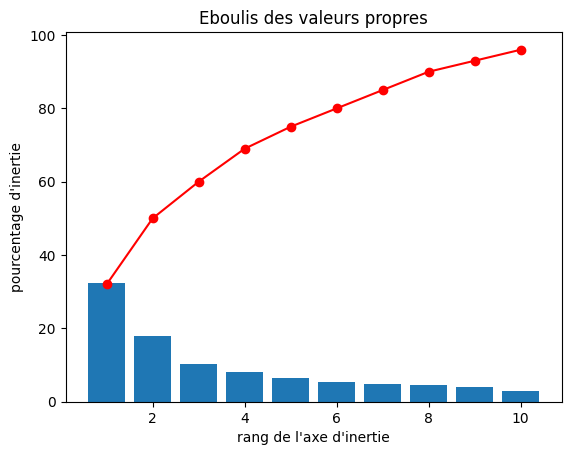

In [ ]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Graphe de corrélation

In [ ]:
x, y = 0,1

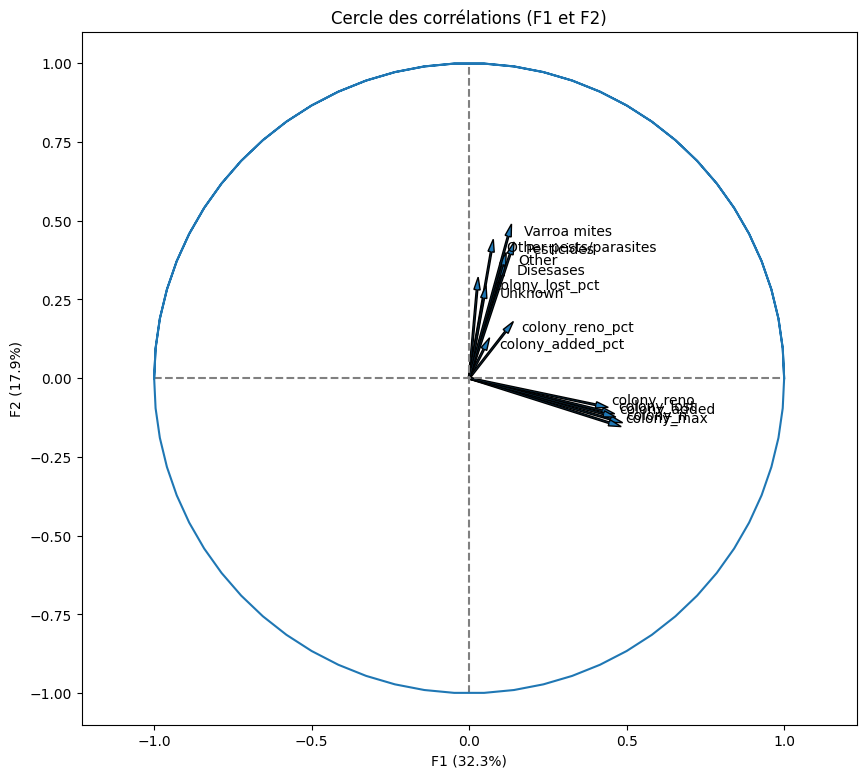

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.02,
             head_length=0.04,
             width=0.005,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.001,
             features[i])

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'i nertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 3 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

### Représentation dans un plan

In [ ]:
pcs

array([[-0.78892737,  0.23105345, -0.78079126, ...,  0.37308016,
         0.7182884 ,  0.70238394],
       [-0.64705077, -0.37257776, -0.08529976, ...,  0.67080807,
         0.0996689 ,  0.4718904 ],
       [-1.02913949, -0.88737223, -0.25993487, ...,  0.24252248,
         0.35115903,  0.47084356],
       ...,
       [-0.13872031, -0.09371023,  1.17230501, ..., -1.31821282,
         0.7153169 ,  0.96958438],
       [-0.5479055 , -0.88422331,  1.64687706, ..., -0.26493834,
         1.0822579 ,  0.39157153],
       [-0.18584662,  0.59711611,  3.20287024, ..., -0.64334575,
        -0.18796476, -1.90121405]])

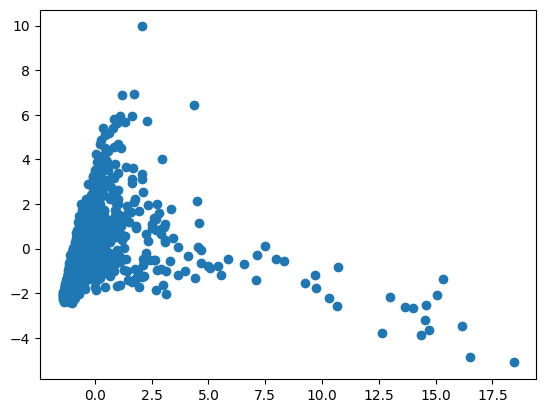

In [ ]:
plt.scatter(pcs[:, 0], pcs[:, 1])
#add_labels(pcs[:, 0], pcs[:, 1], names)
plt.show()

#### Représentation avec scatterplot

In [ ]:
X = df.iloc[:, 5:] #récupérer les 5 colonnes apèrs
X.shape

(1148, 14)

In [ ]:
sc = StandardScaler().set_output(transform="pandas")
X_scaled = sc.fit_transform(X)
X_scaled.head(5)

,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_added_pct,colony_reno,colony_reno_pct,Disesases,Other,Other pests/parasites,Pesticides,Unknown,Varroa mites
0,-0.367481,-0.377936,-0.285268,2.013237,-0.233038,1.120900,-0.303700,-0.357324,-0.515747,0.447534,-0.416097,-0.441017,0.986113,-1.044146
1,-0.184273,-0.231265,-0.165513,0.234447,-0.208728,-0.260344,-0.223552,-0.145385,-0.501084,-0.653648,0.703649,-0.673730,-0.193484,-0.169669
2,-0.328222,-0.341268,-0.298099,-0.039213,-0.297865,-0.282396,-0.310632,-0.675233,-0.295796,-0.774325,0.028835,-0.314083,-0.586683,-0.650890
3,9.008796,8.438002,10.544019,0.508107,9.782699,0.088405,5.057548,-0.039416,-0.075846,0.055332,-0.282617,0.119609,-0.249656,-0.283507
4,-0.390381,-0.349126,-0.298099,0.097617,-0.338382,-0.442773,-0.308466,-0.675233,-0.251806,-0.532970,-0.749796,-0.610263,0.330781,-0.806123


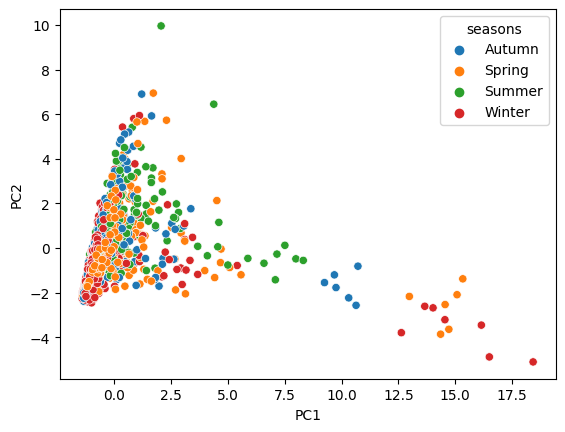

In [ ]:
#columns = data.columns
#hue = cls.labels_ (cls -> après fit)
#data = dataframe (sans variables quantitatives)
'''
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):'''

ax, pca = scatterplot_pca(columns=X_scaled.columns, data=X_scaled, hue=names)

## K-means pour déterminer nombre de clusters

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
def kmeans_dataset(dataset, n_clusters_list, strategies, tries) :
  for n_clusters in n_clusters_list:
    for strategy in strategies:
      for rs in range(tries):
        inertia = (KMeans (n_clusters = n_clusters, n_init = 1,random_state = rs,init=strategy).fit(dataset).inertia_)
        yield rs, strategy, n_clusters, inertia

In [ ]:
gen = kmeans_dataset(X_scaled, range(2, 10), ["k-means++"], 20)

In [ ]:
res = pd.DataFrame(gen, columns=["seed", "init", "n_clusters", "inertia"])
res = res.astype({
  "seed": "int32",
  "n_clusters": "int32"
})


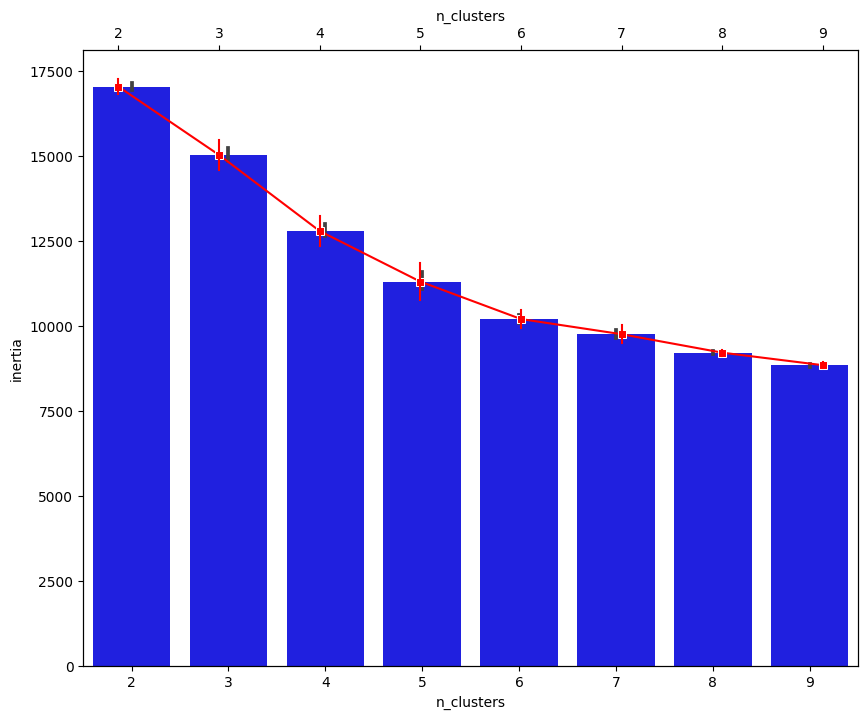

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection=None)
ax2 = ax1.twiny()
sns.barplot(x="n_clusters", y="inertia", data=res, color="blue", ax=ax1)

sns.lineplot(x="n_clusters", y="inertia", marker="s", data=res.loc[res.init == "k-means++"], err_style="bars", errorbar="sd", color="red", ax=ax2)

plt.show()

In [ ]:
limit = int((X_scaled.shape[0]//2)**0.5)

for k in range(2, limit+1):
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(X_scaled)
    pred = model.predict(X_scaled)
    score = silhouette_score(X_scaled, pred)
    print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))

Silhouette Score for k = 2: 0.600
Silhouette Score for k = 3: 0.193
Silhouette Score for k = 4: 0.210
Silhouette Score for k = 5: 0.275
Silhouette Score for k = 6: 0.286
Silhouette Score for k = 7: 0.291
Silhouette Score for k = 8: 0.262
Silhouette Score for k = 9: 0.266
Silhouette Score for k = 10: 0.266
Silhouette Score for k = 11: 0.272
Silhouette Score for k = 12: 0.282
Silhouette Score for k = 13: 0.266
Silhouette Score for k = 14: 0.245
Silhouette Score for k = 15: 0.275
Silhouette Score for k = 16: 0.252
Silhouette Score for k = 17: 0.239
Silhouette Score for k = 18: 0.215
Silhouette Score for k = 19: 0.227
Silhouette Score for k = 20: 0.220
Silhouette Score for k = 21: 0.203
Silhouette Score for k = 22: 0.235
Silhouette Score for k = 23: 0.221


Résultat de la méthode **silouhette score** : 2 classes ou alors 8 classes

Visualisation avec la **méthode du coude** : plutôt 6 classes ?

-> utilisation de 6 classes car sinon, avec plus de classes, la Californie est séparée en plusieurs classes et ça ne semble rien apporter pour les autres états

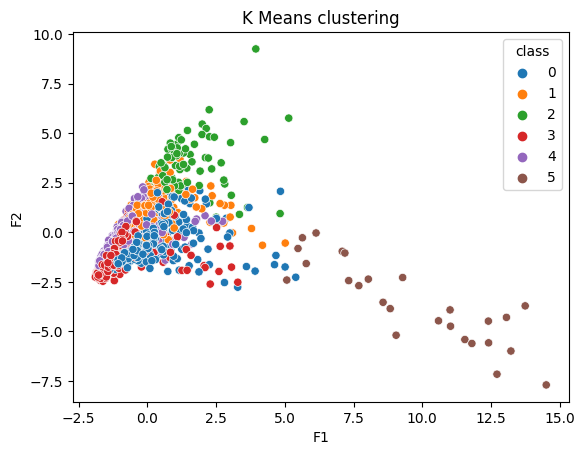

In [ ]:
k = 6

model = KMeans(n_clusters = k, init="k-means++", n_init=10)
pred = model.fit(X_scaled)

scatterplot_pca(columns=X_scaled.columns, hue=pred.labels_, data=X_scaled)

'''
# plotting the cluster centroids
plt.scatter(model.cluster_centers_[:, 0],
            model.cluster_centers_[:, 1],
            s = 30,  # marker size
            c = 'black')
add_labels(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], range(0,k+1))
'''

#sns.scatterplot(x=model.cluster_centers_[:,1], y=model.cluster_centers_[:,3], color='black',marker='*', label='centroid', s=200)

plt.title('K Means clustering')
plt.xlabel('F1')
plt.ylabel('F2')
plt.show()

In [ ]:
y = model.labels_
#X_scaled["labels"] = model.labels_
#X_scaled.head(5)

In [ ]:
'''
dico_groupes = {}

for index, row in X_scaled.iterrows():
  dico_groupes[int(row['labels'])] = {}

for index, row in X_scaled.iterrows():
  groupe = int(row['labels'])
  if(names[index] not in dico_groupes[groupe]) :
    dico_groupes[groupe][names[index]] = 0
  else :
    dico_groupes[groupe][names[index]] = dico_groupes[groupe][names[index]] + 1

for e in dico_groupes :
  print('Groupe '+str(e))
  for i in dico_groupes[e] :
    if(dico_groupes[e][i] != 0) :
      print("\t"+ i + " : "+str(dico_groupes[e][i]))
  print("\n")
'''

'\ndico_groupes = {}\n\nfor index, row in X_scaled.iterrows():\n  dico_groupes[int(row[\'labels\'])] = {}\n    \nfor index, row in X_scaled.iterrows():\n  groupe = int(row[\'labels\'])\n  if(names[index] not in dico_groupes[groupe]) :\n    dico_groupes[groupe][names[index]] = 0\n  else :\n    dico_groupes[groupe][names[index]] = dico_groupes[groupe][names[index]] + 1\n\nfor e in dico_groupes :\n  print(\'Groupe \'+str(e))\n  for i in dico_groupes[e] :\n    if(dico_groupes[e][i] != 0) :\n      print("\t"+ i + " : "+str(dico_groupes[e][i]))\n  print("\n")\n'

## Classification ascendate hiérarchique

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
cls = AgglomerativeClustering(linkage="ward", affinity="euclidean",  distance_threshold=0, n_clusters=None)
cls.fit(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', distance_threshold=0,
                        n_clusters=None)

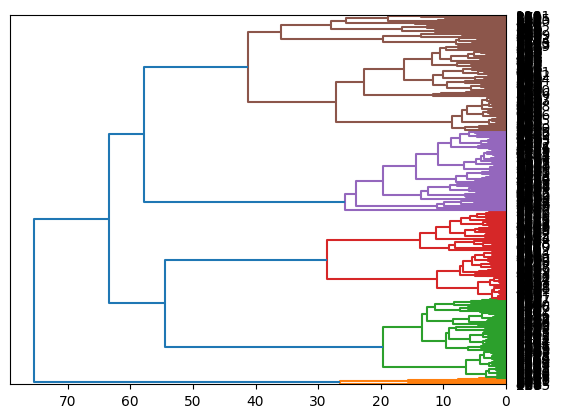

In [ ]:
plot_dendrogram(cls, orientation="left")
plt.show()

## Analyse de différents classifieurs

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

### K-plus proches voisins

In [ ]:
y = names

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8)

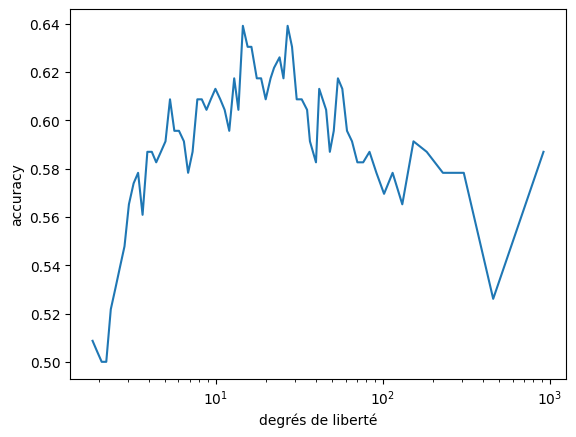

In [ ]:
# trouver le Kopt

n_neighbors_list = np.unique(np.round(np.geomspace(1, 500,100)).astype(int))
gen = knn_simple_validation(X_train, y_train, X_test, y_test,n_neighbors_list)
df = pd.DataFrame(gen, columns=["# neighbors", "accuracy", "degrés de liberté"])
sp = sns.lineplot(x="degrés de liberté", y="accuracy", data=df)
sp.set(xscale="log")
plt.show()

In [ ]:
Kopt = df.groupby("# neighbors").mean().accuracy.idxmax()
Kopt

34

(<Axes: xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

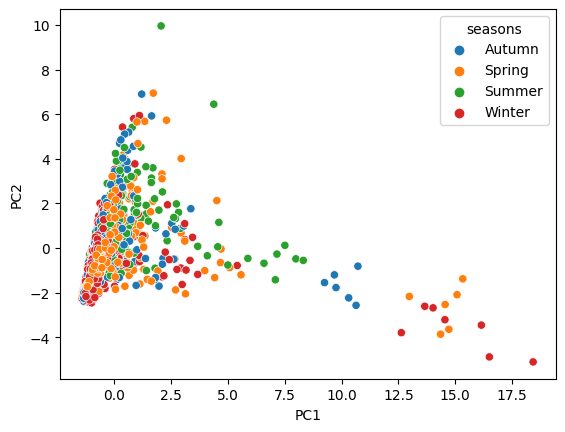

In [ ]:
#visualisation d'un modèle avec le K optimal

cls = KNeighborsClassifier(n_neighbors=Kopt)
cls.fit(X_scaled, y)
plot_clustering(X_scaled, y)


In [ ]:
# De 1 à 500 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500,100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}
cls = KNeighborsClassifier()
search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
accuracy_score(y_pred, y_test)

0.6173913043478261

In [ ]:
Kopt_search = search.best_params_["n_neighbors"]
print(Kopt_search)

71


### LDA, QDA et Naive Bayes Gaussien

In [ ]:
models = [
  (LinearDiscriminantAnalysis, "LDA"),
  (QuadraticDiscriminantAnalysis, "QDA"),
  (GaussianNB, "NB"),
]

def validation_errors(X, y, models):
  for model, name in models:
    for acc in cross_val_score(model(), X, y, cv=10):
      yield name, acc


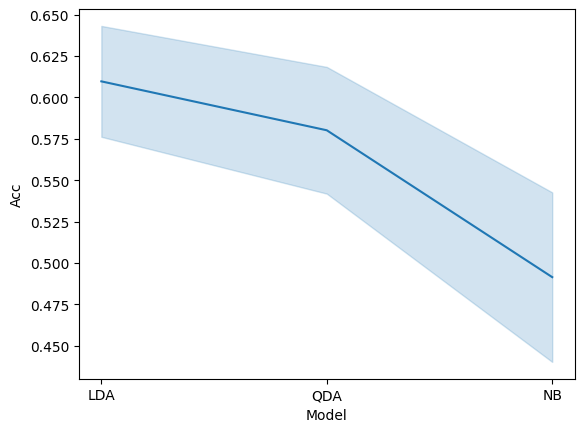

In [ ]:
import warnings
warnings.filterwarnings('ignore')

df = pd.DataFrame(validation_errors(X_scaled, y, models), columns=["Model","Acc"])
sns.lineplot(x="Model", y="Acc", data=df, errorbar='sd')
plt.show()


In [ ]:
test = cross_val_score(LinearDiscriminantAnalysis(), X_scaled, y, cv=10)
test

array([0.59130435, 0.6       , 0.6       , 0.64347826, 0.64347826,
       0.55652174, 0.64347826, 0.6173913 , 0.56140351, 0.64035088])

In [ ]:
model = LinearDiscriminantAnalysis()
model.fit(X_scaled, y)
model.explained_variance_ratio_

array([0.72924917, 0.23614821, 0.03460262])

In [ ]:
a = {'F1': pcs[:, 0], 'F2': pcs[:, 1]}
data_pca = pd.DataFrame(data = a)

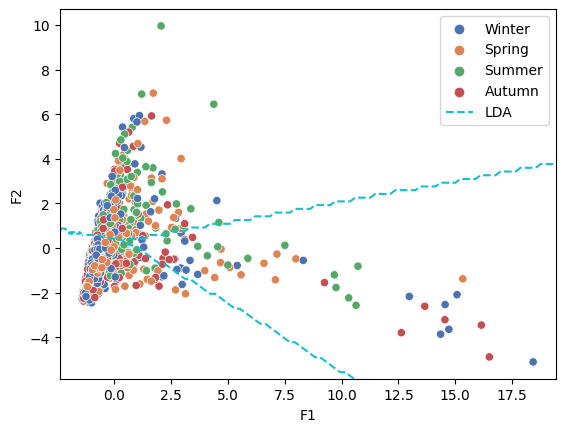

In [ ]:
model = LinearDiscriminantAnalysis()
model.fit(data_pca, y)
colors = sns.color_palette()

sns.scatterplot(x="F1", y="F2", data=data_pca, hue=y, palette="deep")
add_decision_boundary(model, color=colors.pop(), region=False, label="LDA")
plt.show()

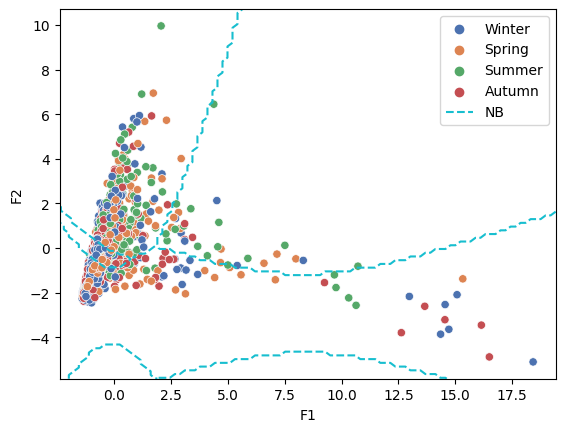

In [ ]:
model = GaussianNB()
model.fit(data_pca, y)
colors = sns.color_palette()

sns.scatterplot(x="F1", y="F2", data=data_pca, hue=y, palette="deep")
add_decision_boundary(model, color=colors.pop(), region=False, label="NB")
plt.show()

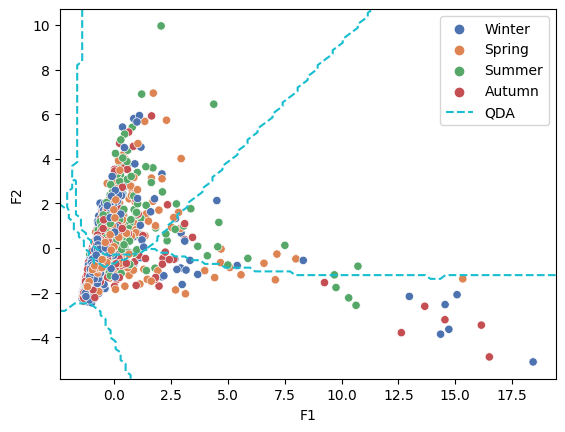

In [ ]:
model = QuadraticDiscriminantAnalysis()
model.fit(data_pca, y)
colors = sns.color_palette()

sns.scatterplot(x="F1", y="F2", data=data_pca, hue=y, palette="deep")
add_decision_boundary(model, color=colors.pop(), region=False, label="QDA")
plt.show()

### Arbres de décision

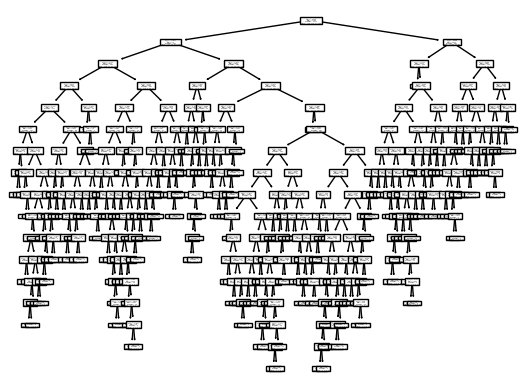

In [ ]:
#sur les données complètes
cls = DecisionTreeClassifier()
cls.fit(X_scaled, y)
plot_tree(cls)
plt.show()

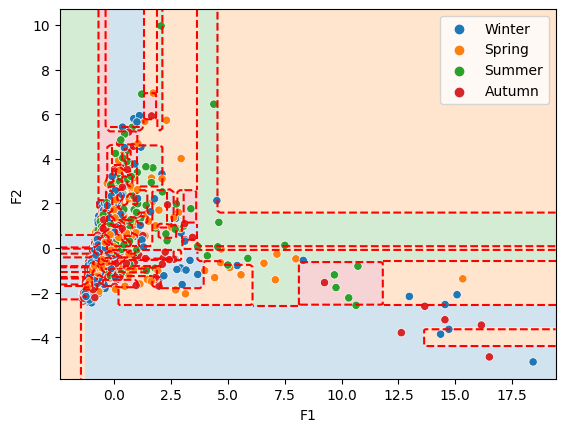

In [ ]:
cls = DecisionTreeClassifier()
cls.fit(data_pca, y)
sns.scatterplot(x="F1", y="F2", hue=y, data=data_pca)
add_decision_boundary(cls)
plt.show()

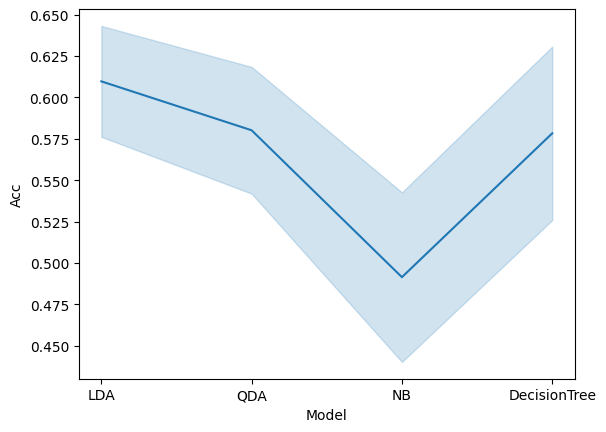

In [ ]:
all_models = [
  (LinearDiscriminantAnalysis, "LDA"),
  (QuadraticDiscriminantAnalysis, "QDA"),
  (GaussianNB, "NB"),
  (DecisionTreeClassifier, "DecisionTree")
]


df = pd.DataFrame(validation_errors(X_scaled, y, all_models), columns=["Model","Acc"])
sns.lineplot(x="Model", y="Acc", data=df, errorbar='sd')
plt.show()

### Random forest (+ tous les classifieurs)

In [ ]:
acc_randomforest = cross_val_score(RandomForestClassifier(n_estimators=100), X_scaled, y, cv=10)
a = {"Model" : ["RandForest", "RandForest","RandForest","RandForest","RandForest","RandForest","RandForest","RandForest","RandForest","RandForest"], "Acc" : acc_randomforest }
b = pd.DataFrame(data=a)
df2 = pd.concat([df, b])
acc_kvoisins = cross_val_score(KNeighborsClassifier(n_neighbors=Kopt), X_scaled, y, cv=10)
a = {"Model" : ["Kvoisins", "Kvoisins", "Kvoisins", "Kvoisins", "Kvoisins", "Kvoisins", "Kvoisins", "Kvoisins", "Kvoisins", "Kvoisins"], "Acc" : acc_kvoisins}
b = pd.DataFrame(data=a)
df3 = pd.concat([df2, b])

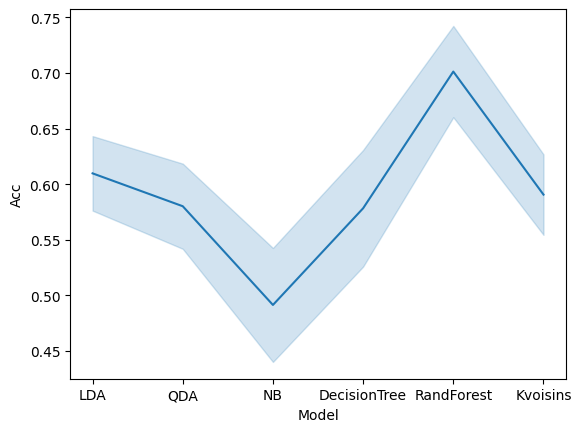

In [ ]:
sns.lineplot(x="Model", y="Acc", data=df3, errorbar='sd')
plt.show()